<a href="https://colab.research.google.com/github/gigDevelopment10/NanoGrad/blob/main/Nanograd_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nanograd**  - Auto grad engine that influences backpropagation (Kind of mathematical model that trains the neural parameter)

**Backpropagation** - efficiently evaluate the gradient of some kind of loss function that influences the weight of a neural network.


BUILDING A MICROGRAD LIBRARY

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5 

In [ ]:
f(3.0)

20.0

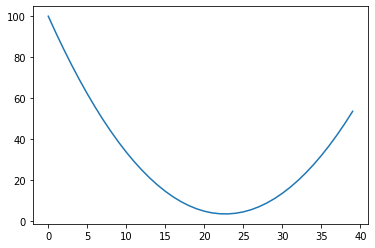

In [ ]:
# arange and plot derivative parabola

xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(ys)

In [ ]:
h = 0.000001
x = 3.0

# Derivative of a function 
slope = (f(x + h) - f(x))/h

# analogy 
# Derivative of 3*x**2  - 4x + 5 = 6x + 4 which means the abv solution is right 

In [ ]:
import math

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None 
    self._prev = set(_children) # store the children of the operators
    self._op = _op
    self.label = label


# _children notation is used for efficiency
  
  def __repr__(self):
    return f"Value(data)={self.data}"

# Internally it runs a.__add__(b) because python can't operate on Value objects 
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  # Internally it runs a.__mul__(b) because python can't operate on Value objects
  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other), '*')

      def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
      out._backward = _backward

      return out
  
  def __pow__(self, other):
    assert isinstance(other, (int , float)), "only support int/float owers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += (other * self.data ** (other-1)) * out.grad 
      out._backward = _backward

      return out
  
  def __rmul__(self, other):
    return Value(self.data * other.data)
  
  def __truediv__(self, other): # self / other
        return Value(self.data * other.data**-1)
      
  def __rtruediv__(self, other): # other / self
        return Value(other.data * self.data**-1)

  def __neg__(self):
    return self * -1 

  def __sub__(self, other):
    return self + (-other)

# Activation function 
  def tanh(self):
    x = self.data 
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad 
    
    out._backward = _backward
    return out 

  def exp(self):
    x = self.data 
    out = Value(math.exp(x), (self,), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
# Topological Sorting 
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data)=-8.0

In [ ]:
print('d._prev: ', d._prev)
print('d._op: ', d._op)

d._prev:  {Value(data)=-6.0, Value(data)=10.0}
d._op:  +


In [ ]:
# !pip install graphviz
from graphviz import Digraph

def trace(root): # root = d
# build a set of nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges 

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in a graph, create a rectangular ('record') node for it 
    dot.node(name = uid, label='{ %s | data %.4f | grad. %.4f }' %(n.label, n.data, n.grad), shape='record')
    
    if n._op:
      # if this value is some result of operation, create an op node for it 
      dot.node(name = uid + n._op, label = n._op)
      # connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

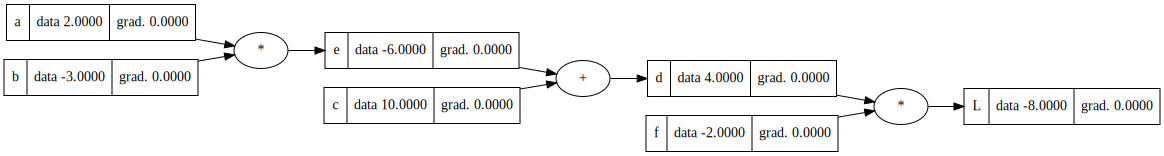

In [ ]:
draw_dot(L)

Run Backpropagation and calculate gradients 

In [ ]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
a.grad = -2.0 * -3.0 
b.grad = -2.0 * 2

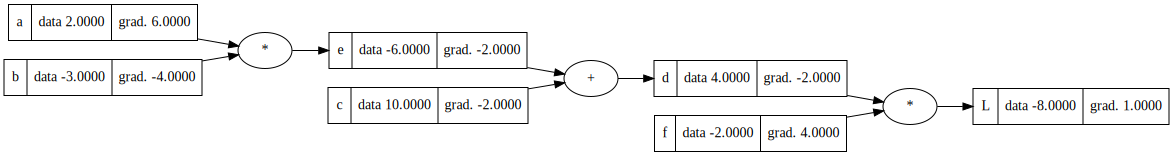

In [ ]:
draw_dot(L)

dd/dc ? 1.0

d= c+e

(f(x+h) - f(x))/h 

((c+h)+e) - (c+e))/h

h/h = 1

dd/dc?=1
dd/de?=1

**Applying chain rule**

dL/dc = dL/dd * dd/dc <br>
dL/dc = -2 * 1 = -2 <br>

with symmetry DL/dc = dL/de = -2.0 <br>

e = b * a <br>
de/da = b = -3.0 <br>

DL/de = -2.0 <br>
DL/da = DL/de * de/da <br>
DL/da = -2.0 * -3.0 = 6 <br>



dd / dc ? 1.0
d = c+e
(f(x+h) - f(x))/h 
((c+h)+e) - (c+e))/h
h/h = 1

In [ ]:
def lol():
  h = 0.001
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1= L.data

  a = Value(2.0 , label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2= L.data

  print((L2 - L1)/h)

lol()

0.0


In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad
e.data += 0.01 * e.grad
f.data += 0.01 * f.grad

e = a * b 
d = e + c
L = d * f 

print(L.data)

-7.286496


**BUILDING A TANH ACTIVATION FUNCTION**

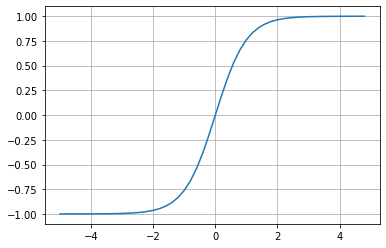

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

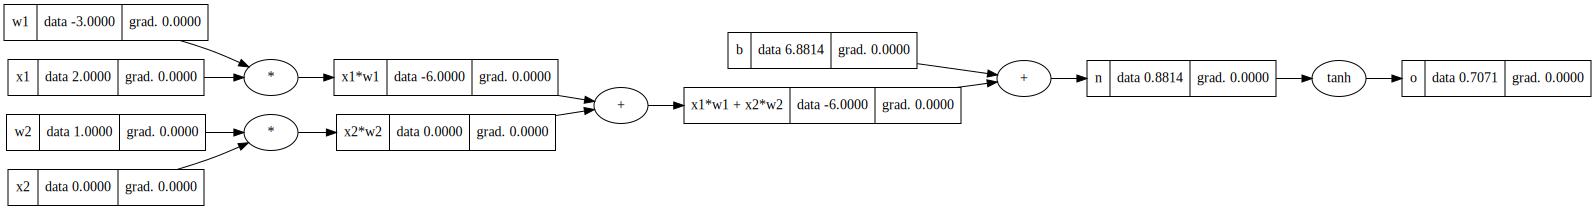

In [ ]:
# building a neural network 

# inputs x1, x2 
x1 = Value(2.0, label ='x1')
x2 = Value(0.0, label ='x2')

# Weights x1, w2 
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label ='w2')

# bias of the neuron 
# 6.7, 8, 6.8813735870195432
b = Value(6.8813735870195432, label ='b')

# x1w1 + x2w2 + b 
x1w1= x1*w1; x1w1.label = 'x1*w1'
x2w2= x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label ='n'
o = n.tanh() ; o.label ='o'

draw_dot(o)


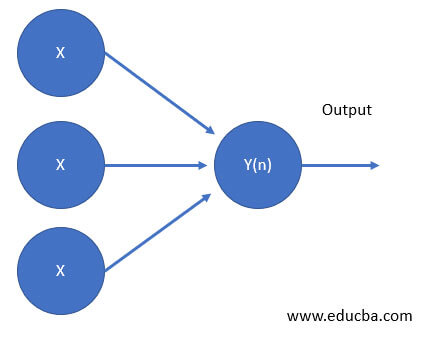

Value(data)=-6.2624


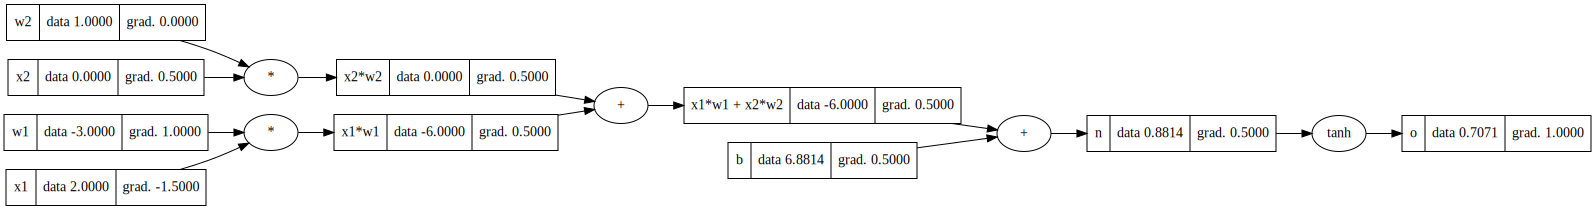

In [ ]:
# building a neural network 

# inputs x1, x2 
x1 = Value(2.0, label ='x1')
x2 = Value(0.0, label ='x2')

# Weights x1, w2 
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label ='w2')

# bias of the neuron 
# 6.7, 8, 6.8813735870195432
b = Value(6.8813735870195432, label ='b')

# x1w1 + x2w2 + b 
x1w1= x1*w1; x1w1.label = 'x1*w1'
x2w2= x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label ='n'
# ------------------------
o = n.tanh(); o.label='o'
print(e)
# o = (e-1) / (e+1)
# # ------------------------
# o.label = 'o'
o.backward()
draw_dot(o)


In [ ]:
o = (e-1) / (e+1)
o

Value(data)=1.3800547278808148

Again back-propagate 

o = tanh(n) <br>
derivative of tanh = 1- tanh(n)**2 <br>
do/dn = 1 - o * * 2 <br>

local derivative 
do/dn = 1 - o.data * * 2


In [ ]:
# local derivative 
o.grad = 1.0

In [ ]:
1 - o.data**2

-0.9045510519461899

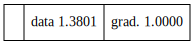

In [ ]:
draw_dot(o)

In [ ]:
# n grad = 1 - tanh(n)**2
n.grad = 0.5

In [ ]:
# + derivative flows equal 
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
# + derivative flows equal 
x1w1.grad = 0.5 * 1
x2w2.grad = 0.5 * 1

In [ ]:
# * derivate 
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
x1.grad = w1.data * x1w1.grad 
w1.grad = x1.data * x1w1.grad 

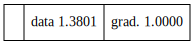

In [ ]:
draw_dot(o)

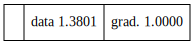

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1.0
o._backward()
# draw_dot(o)

In [ ]:
n._backward()
# draw_dot(o)

In [ ]:
# nothing hapens as b does not have a parent node 
b._backward()
x2w2._backward()
x1w1._backward()

In [ ]:
o.grad = 1.0

# Topological Sorting 
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

for node in reversed(topo):
  node._backward()

In [ ]:
# Topological Sorting 
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data)=1.3800547278808148]

In [ ]:
o.backward()

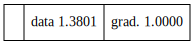

In [ ]:
draw_dot(o)

Fixing Minor Bug <br>


In [ ]:
1.34 

1.34

Value(data)=5.828427124746192


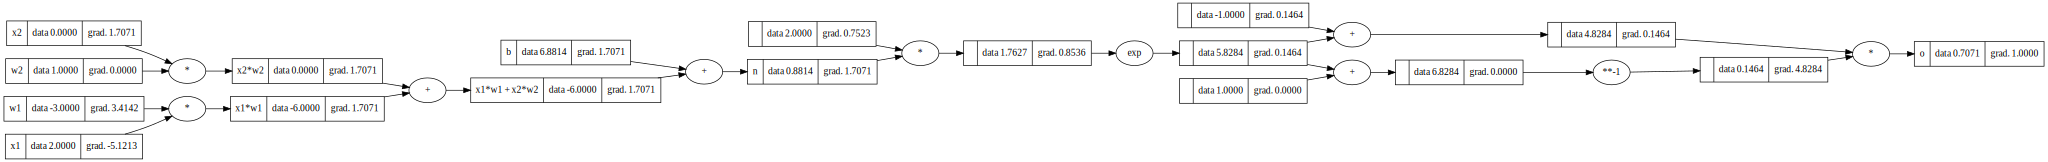

In [ ]:
import math

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None 
    self._prev = set(_children) # store the children of the operators
    self._op = _op
    self.label = label


# _children notation is used for efficiency
  
  def __repr__(self):
    return f"Value(data)={self.data}"

# Internally it runs a.__add__(b) because python can't operate on Value objects 
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  # Internally it runs a.__mul__(b) because python can't operate on Value objects
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int , float)), "only support int/float owers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other *(self.data ** (other-1)) * out.grad 
      out._backward = _backward

    return out
  
  def __rmul__(self, other):
    return self * other
  
  def __truediv__(self, other): # self / other
    return self * (other**-1)
      
  def __rtruediv__(self, other): # other / self
      return other * self**-1

  def __neg__(self):
    return self * -1 

  def __sub__(self, other):
    return self + (-other)

# Activation function 
  def tanh(self):
    x = self.data 
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad 
    
    out._backward = _backward
    return out 

  def exp(self):
    x = self.data 
    out = Value(math.exp(x), (self,), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
# Topological Sorting 
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

# building a neural network 

# inputs x1, x2 
x1 = Value(2.0, label ='x1')
x2 = Value(0.0, label ='x2')

# Weights x1, w2 
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label ='w2')

# bias of the neuron 
# 6.7, 8, 6.8813735870195432
b = Value(6.8813735870195432, label ='b')

# x1w1 + x2w2 + b 
x1w1= x1*w1; x1w1.label = 'x1*w1'
x2w2= x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label ='n'
# ------------------------
e = (2*n).exp()
print(e)
o = (e-1) / (e+1)
# ------------------------
o.label = 'o'
o.backward()
draw_dot(o)



In [ ]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad=True

n = w1*x1 + w2*x2 +b 
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
